In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

city_df = pd.read_csv ('tampa.csv')
read_dis_df = pd.read_csv ('disasters.csv')

/tmp/ipykernel_190539/1217884648.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Declaration Date'] = pd.to_datetime(filtered_df['Declaration Date'].copy())
/tmp/ipykernel_190539/1217884648.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
/tmp/ipykernel_190539/1217884648.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Text(0, 0.5, 'Forclosure Costs')

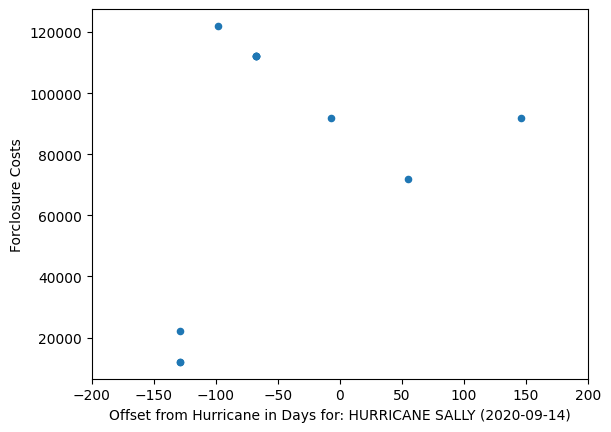

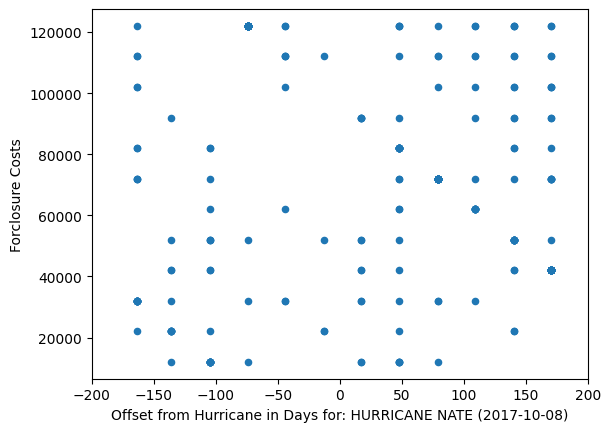

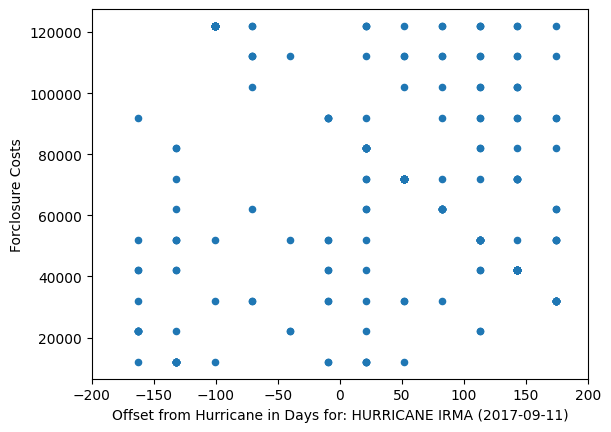

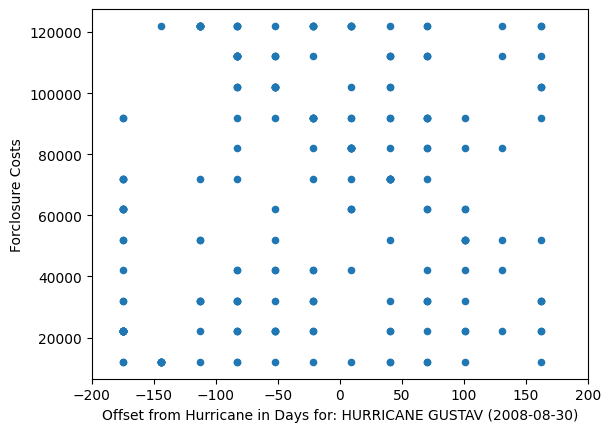

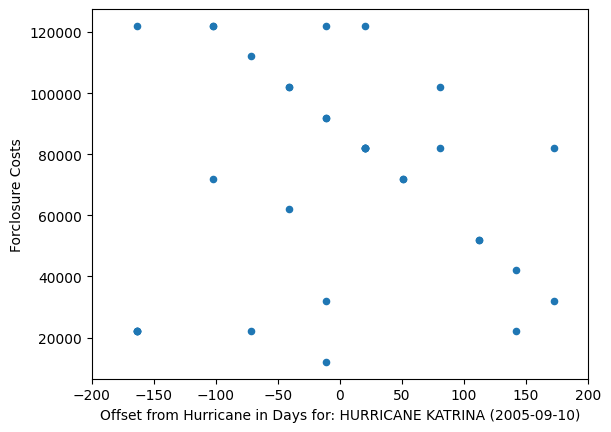

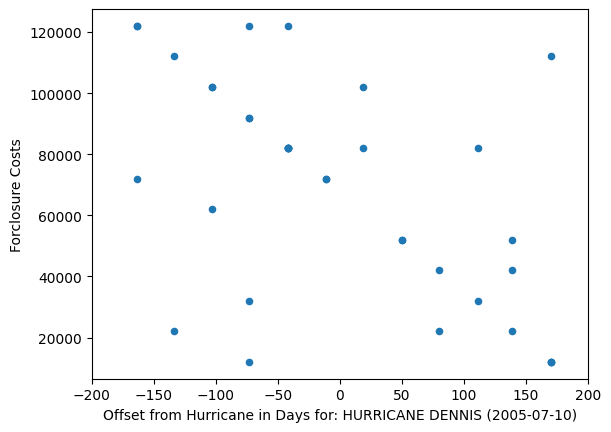

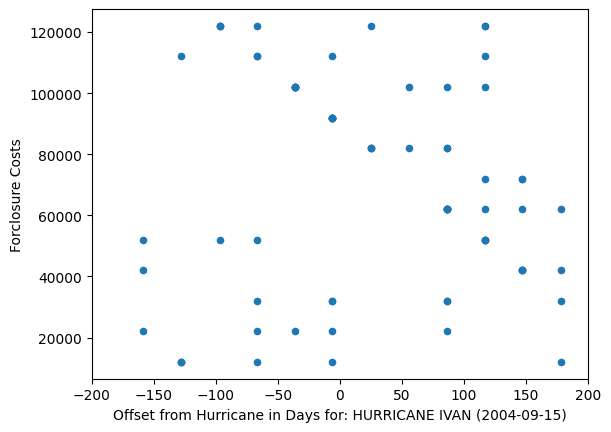

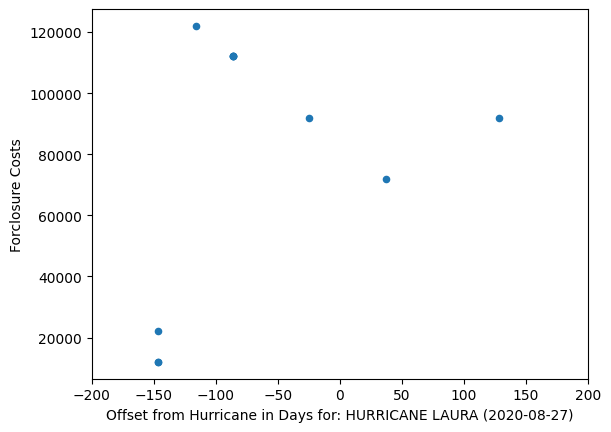

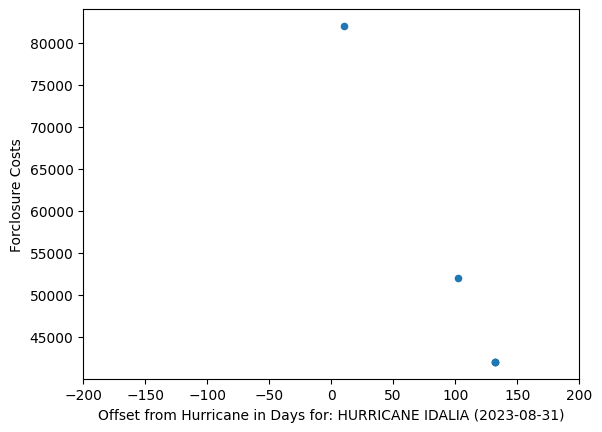

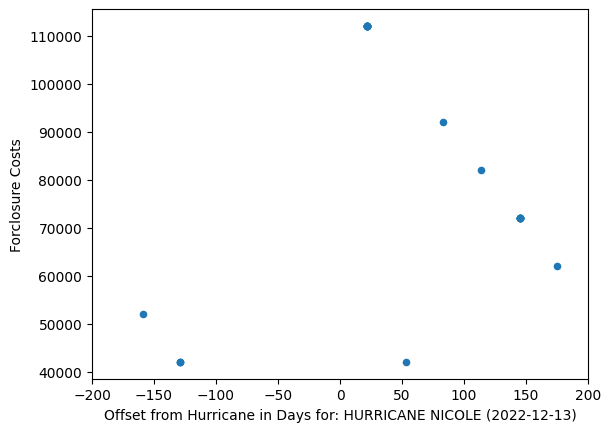

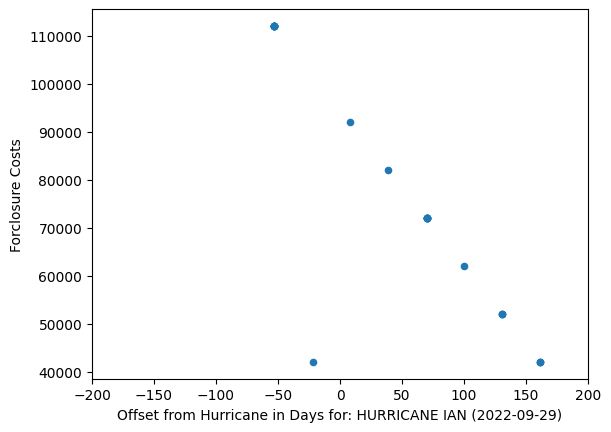

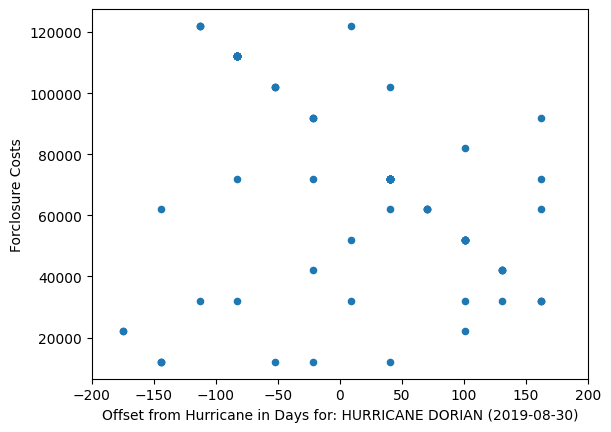

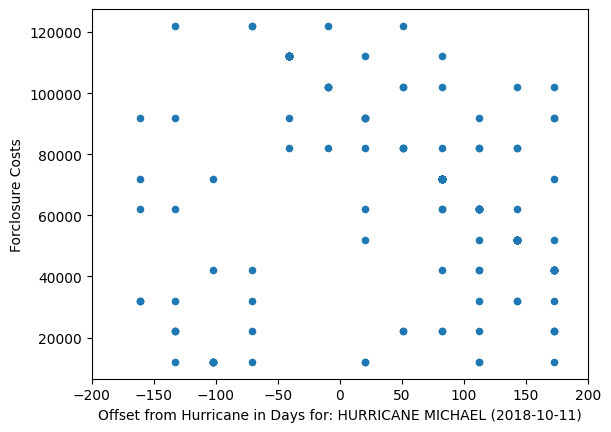

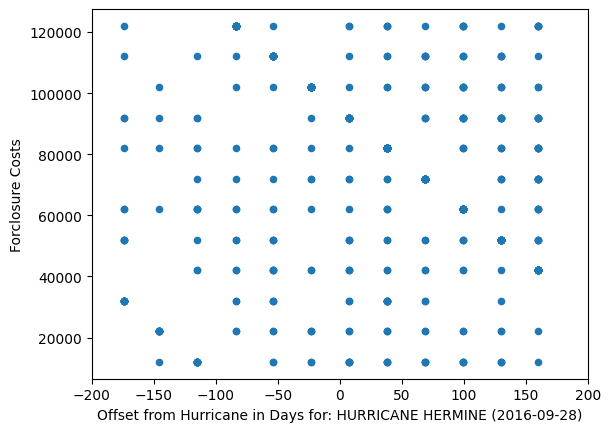

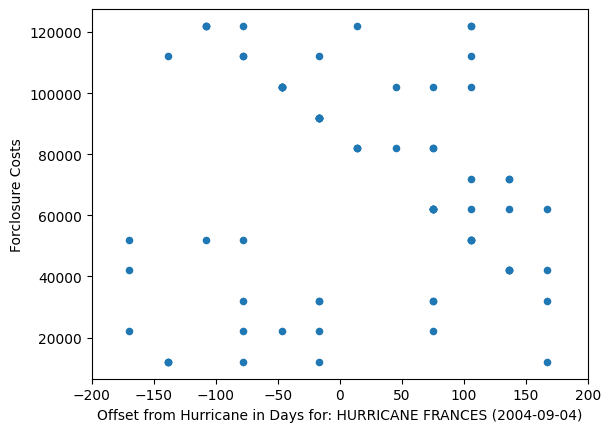

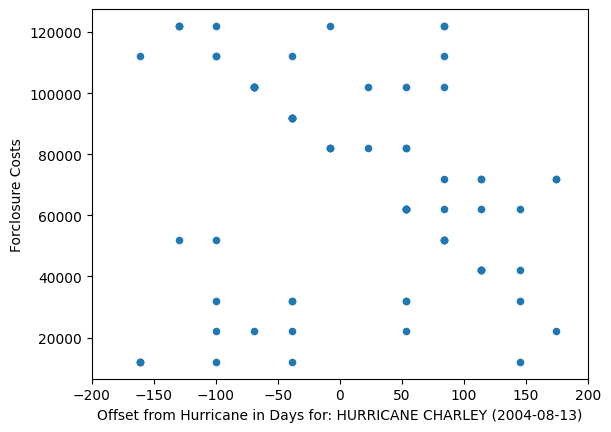

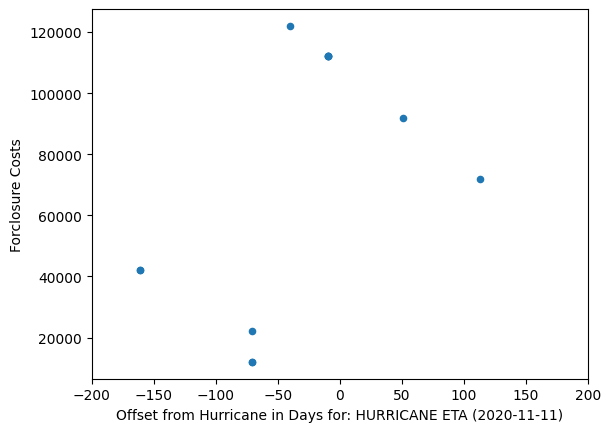

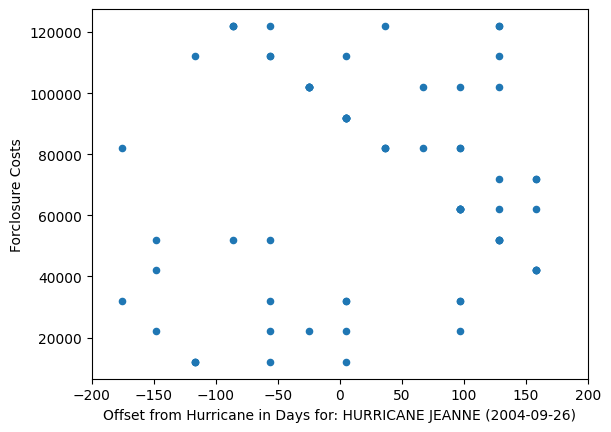

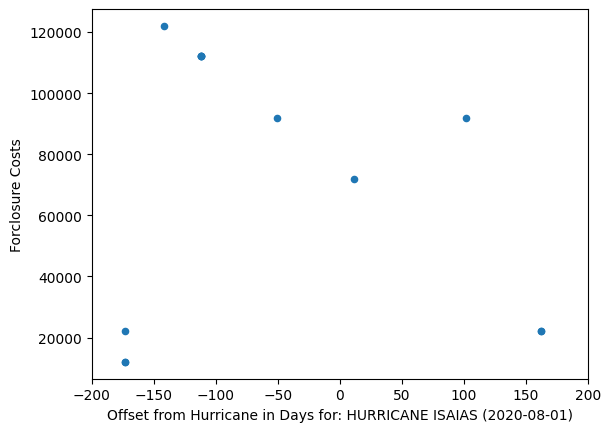

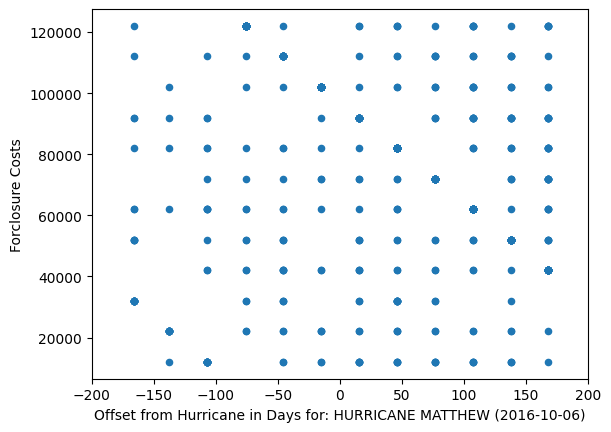

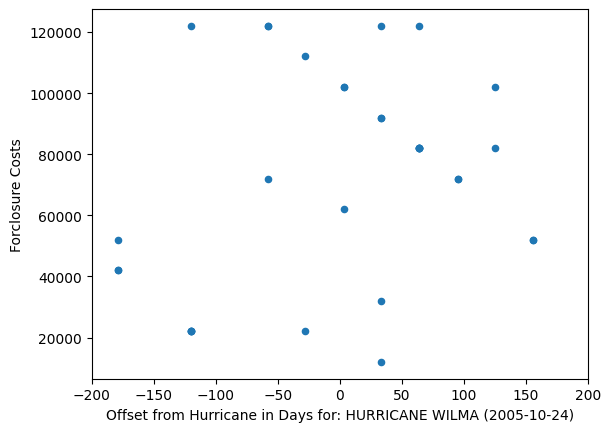

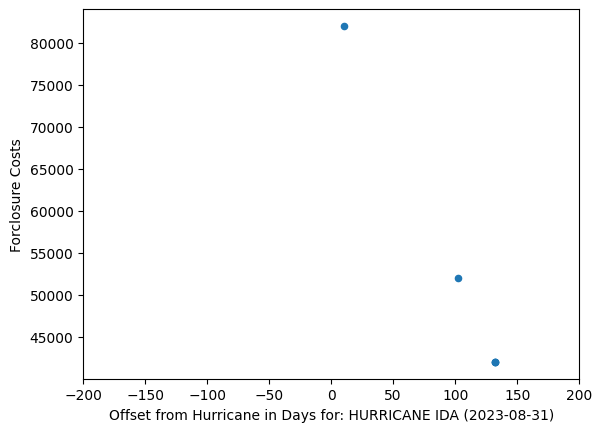

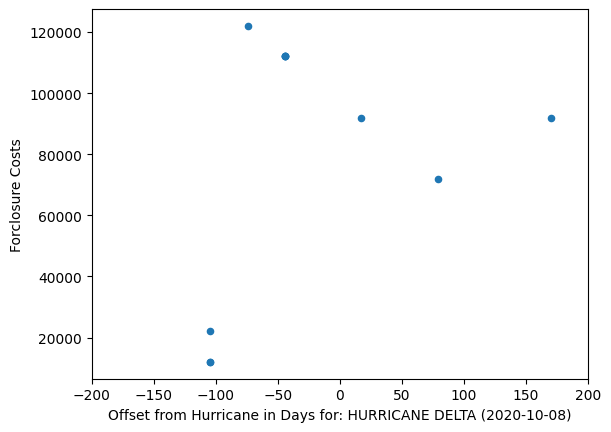

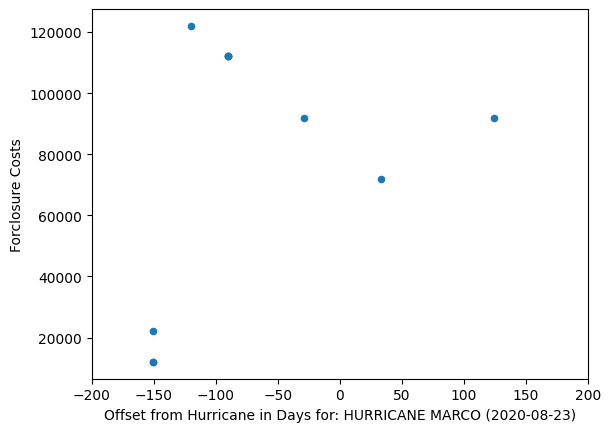

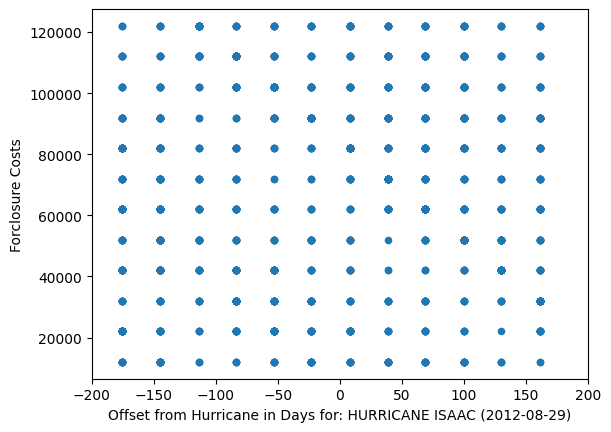

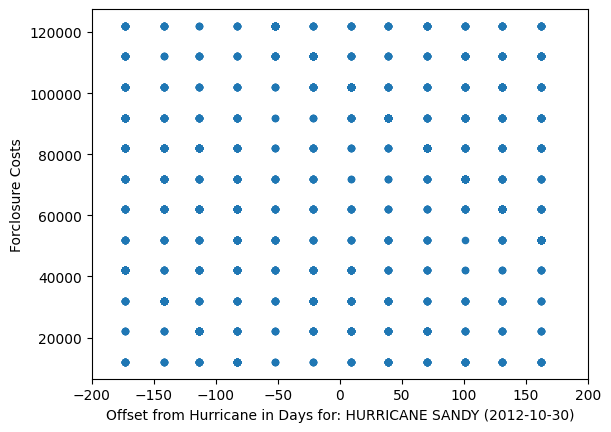

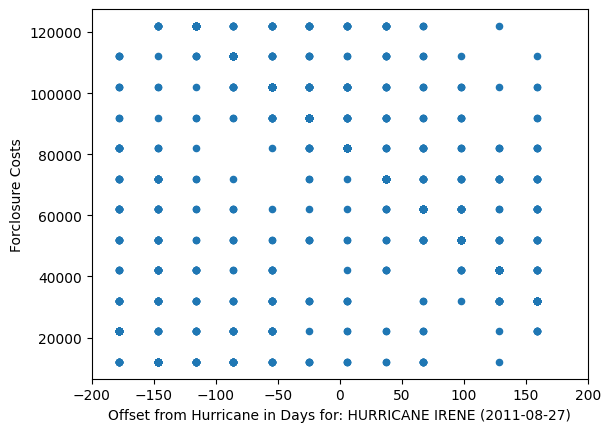

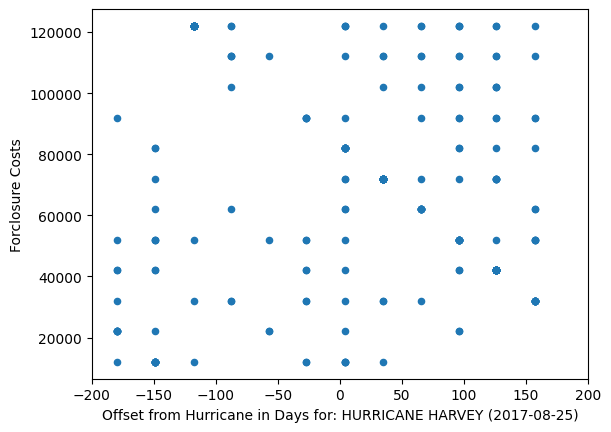

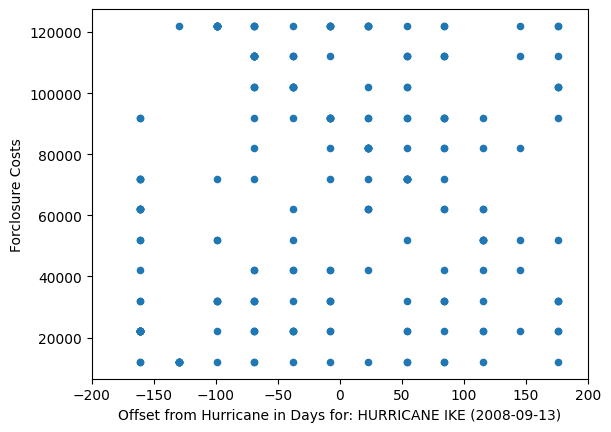

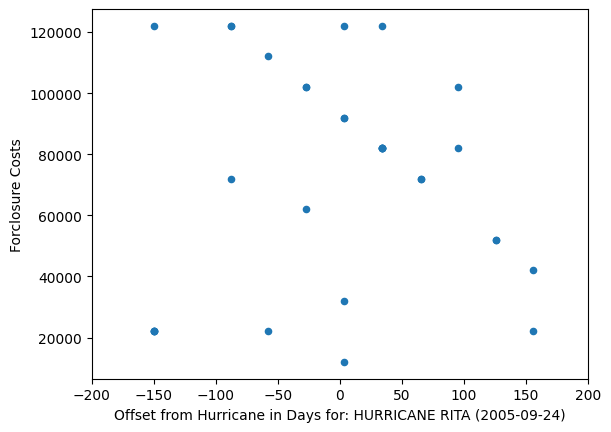

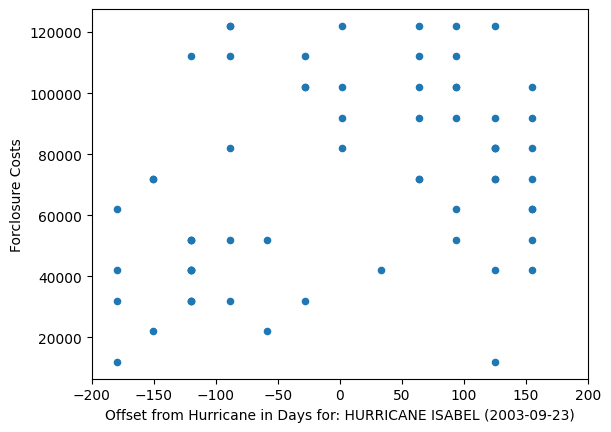

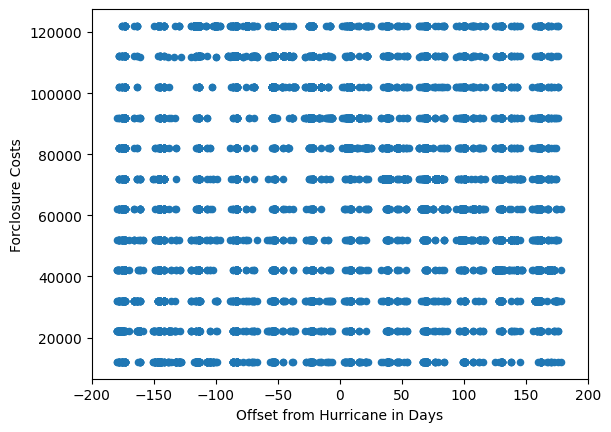

In [6]:
# florida

# filter to match what is in the city
counties = ['Leon County', 'Gadsden County', 'Wakulla County', 'Jefferson County',
                'Hillsborough County', 'Pinellas County',
                'Miami-Dade County']
filtered_df = read_dis_df[read_dis_df['County'].isin(counties)]

# filter it so it doesn't go less than min year in tampa
filtered_df['Declaration Date'] = pd.to_datetime(filtered_df['Declaration Date'].copy())
min_year = city_df['PayYear'].min()
filtered_df = filtered_df[filtered_df['Declaration Date'].dt.year >= min_year]

# get all unique hurricane names
hurricane_names = filtered_df['Declaration Title'].str.extract(r'(HURRICANE\s+\w+)', expand=False).dropna()
hurricane_names = hurricane_names.unique()

disaster_df = pd.DataFrame({'hurricanes': hurricane_names})

# Create a dictionary mapping Hurricane names to Declaration Dates
hurricane_date_mapping = {}

for hurricane_name in disaster_df['hurricanes']:
    # Find matching Declaration Titles (considering variations)
    matching_titles = filtered_df[filtered_df['Declaration Title'].str.contains(hurricane_name, case=False)]['Declaration Title']
    if not matching_titles.empty:
        # Use the first matching Declaration Date
        hurricane_date_mapping[hurricane_name] = filtered_df.loc[filtered_df['Declaration Title'] == matching_titles.iloc[0], 'Declaration Date'].values[0]

# add in declaration date to new df
disaster_df['date'] = pd.to_datetime(disaster_df['hurricanes'].map(hurricane_date_mapping))

# add 6 months prior and after
disaster_df['-6 months'] = disaster_df['date'] - pd.DateOffset(months=6)
disaster_df['+6 months'] = disaster_df['date'] + pd.DateOffset(months=6)

# convert tampa data to date
city_df['date'] = pd.to_datetime(dict(year=city_df['Foreclosure_date']%10000, month=city_df['Foreclosure_date']/10000, day=1))

# init master scatter
master_fl_df = pd.DataFrame()

housing_info = 'Foreclosure_costs'

# go through each hurricane
for x in range(0, len(disaster_df)):
    curr_date = disaster_df.loc[x, 'date']
    start = disaster_df.loc[x, '-6 months']
    end = disaster_df.loc[x, '+6 months']
    hurricane = disaster_df.loc[x, 'hurricanes']

    # now for housing data
    mask = (city_df['date'] >= start) & (city_df['date'] <= end)
    filter_df = city_df[mask]
    scatter_df = filter_df
    scatter_df.loc[:, 'offset'] = (curr_date - filter_df['date'])
    scatter_df.loc[:, 'Offset from Hurricane'] = (scatter_df.copy())['offset'].dt.days

    # add to master list
    if master_fl_df.empty:
        master_fl_df = scatter_df.copy()
    else:
        master_fl_df = pd.concat([master_fl_df.copy(), scatter_df.copy()], ignore_index=True)

    timestamp = pd.Timestamp(curr_date)

    data = scatter_df.dropna(subset=[housing_info])
    ax = data.plot.scatter(x='Offset from Hurricane', y=housing_info)
    ax.set_xlim(left=-200, right=200)
    plt.xlabel('Offset from Hurricane in Days for: ' + hurricane + ' (' + timestamp.strftime('%Y-%m-%d') + ')')
    plt.ylabel('Forclosure Costs')

data = master_fl_df
ax = data.plot.scatter(x='Offset from Hurricane', y=housing_info)
ax.set_xlim(left=-200, right=200)
plt.xlabel('Offset from Hurricane in Days')
plt.ylabel('Forclosure Costs')